# TREC

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gensim.downloader

In [3]:
# Load training and development datasets
df_train=pd.read_csv("../datasets/TREC/train.csv")
df_train["text"] = df_train["text"].str.lower()

# Load test dataset
df_test=pd.read_csv("../datasets/TREC/test.csv")
df_test["text"] = df_test["text"].str.lower()

In [4]:
# Split the training dataset to create a development set of 500 examples
train_data, dev_data = train_test_split(df_train, test_size=500, random_state=42)

# Rename the test dataset to synchronize the namings
test_data = df_test

len(train_data), len(dev_data), len(test_data)

(4952, 500, 500)

## Update Word2Vec

In [5]:
# Download the "glove-twitter-25" embeddings
w2v = gensim.downloader.load('word2vec-google-news-300')

In [6]:
# Out-of-vocabulary (OOV) words
# 1. can be replaced with a special token, such as "<OOV>" or "<UNK>"
# 2. can be ignored

word2idx = w2v.key_to_index

# Add '<UNK>' and '<PAD>' tokens to the vocabulary index
word2idx['<UNK>'] = len(word2idx)
word2idx['<PAD>'] = len(word2idx)

print(f"word2idx['<UNK>']: {word2idx['<UNK>']}")
print(f"word2idx['<PAD>']: {word2idx['<PAD>']}")

word2idx['<UNK>']: 3000000
word2idx['<PAD>']: 3000001


In [7]:
# Add the '<UNK>' word to the vocabulary of the Word2Vec model 
# Initialize it with the average of all word vectors int he pretrained embeddings
unk_vector = np.mean(w2v.vectors, axis=0)
w2v.vectors = np.vstack([w2v.vectors, unk_vector])
print("after insert UNK: ", w2v.vectors.shape)

# Add the '<PAD>' word to the vocabulary of the Word2Vec model 
# Initialize it with a row of zeros in the vectors matrix
w2v.vectors = np.vstack([w2v.vectors, np.zeros(w2v.vectors[0].shape)])
print("after insert UNK: ", w2v.vectors.shape)

after insert UNK:  (3000001, 300)
after insert UNK:  (3000002, 300)


## Modify Class Labels

In [8]:
# Get unique coarse labels
unique_labels = train_data['label-coarse'].unique()

# Randomly select 4 classes
np.random.seed(19260817)
selected_labels = np.random.choice(unique_labels, size=4, replace=False)

# ****** 6 == OTHERS !!!!!! IMPORTANT 
# update: 6 will cause error, change back to OTHERS then transform later

train_data['new_label'] = train_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
dev_data['new_label'] = dev_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")
test_data['new_label'] = test_data['label-coarse'].apply(lambda x: x if x in selected_labels else "OTHERS")

# Display the unique labels in the updated training set
train_data['new_label'].unique()

array([2, 0, 'OTHERS', 4, 3], dtype=object)

In [9]:
# Encode labels for easier reference in the following part
label_encoder = LabelEncoder()

test_data['new_label'] = test_data['new_label'].astype(str)
test_data["label_transformed"] = label_encoder.fit_transform(test_data['new_label'])

train_data['new_label'] = train_data['new_label'].astype(str)
train_data["label_transformed"] = label_encoder.fit_transform(train_data['new_label'])

dev_data['new_label'] = dev_data['new_label'].astype(str)
dev_data["label_transformed"] = label_encoder.fit_transform(dev_data['new_label'])

/opt/homebrew/Caskroom/miniforge/base/envs/env_python3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/env_python3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/env_python3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/homebrew/Caskroom/miniforge/base/envs/env_python3.9/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: 

In [10]:
train_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
4943,2,34,what is mikhail gorbachev 's middle initial ?,2,1
2346,0,0,how does the tail affect the flight of a kite ?,0,0
1835,5,21,what were the first three cities to have a pop...,OTHERS,4
4047,1,1,what is the movie jonathan livingstone seagull ?,OTHERS,4
5097,1,23,what is a fear of home surroundings ?,OTHERS,4


In [11]:
dev_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
3408,5,21,what city is served by tempelhol airport ?,OTHERS,4
371,1,2,what is dudley do-right 's horse 's name ?,OTHERS,4
453,0,9,what 's nature 's purpose for tornadoes ?,0,0
290,0,12,what is the history of valentine 's day cards ?,0,0
4457,3,4,what president became chief justice after his ...,3,2


In [12]:
test_data.head()

,label-coarse,label-fine,text,new_label,label_transformed
0,4,40,how far is it from denver to aspen ?,4,3
1,5,21,"what county is modesto , california in ?",OTHERS,4
2,3,12,who was galileo ?,3,2
3,0,7,what is an atom ?,0,0
4,4,8,when did hawaii become a state ?,4,3


## Handle Out of Vocabulary and Pad Sentence (i.e. Add \<UNK> && \<PAD>)

In [13]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

def sentence_to_indices(sentence, vocab):
    return [vocab.get(word, vocab.get('<UNK>')) for word in sentence]

class TRECDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = [torch.tensor(sentence_to_indices(sentence, vocab)) for sentence in sentences]
        self.labels = [torch.tensor(label) for label in labels]
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        return self.sentences[idx], self.labels[idx]

def collate_fn(batch):
    sentences, labels = zip(*batch)
    sentences_padded = pad_sequence(sentences, batch_first=True, padding_value=word2idx['<PAD>'])
    return sentences_padded, labels

# Create PyTorch datasets and data loaders
train_dataset = TRECDataset(train_data['text'], train_data['label_transformed'], word2idx)
dev_dataset = TRECDataset(dev_data['text'], dev_data['label_transformed'], word2idx)
test_dataset = TRECDataset(test_data['text'], test_data['label_transformed'], word2idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Training, Evaluation and Visualization function

**Since Dataloader is fixed, try to use below functions for easy-training-implementation**

In [14]:
from sklearn.metrics import f1_score

In [44]:
def train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer):
    train_losses = []
    dev_losses = []
    train_accuracies = []
    dev_accuracies = []
    y_true = []
    y_pred = []
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        for sentences, label_tuple in train_loader:
            model.zero_grad()
            labels = torch.stack(label_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracies.append(100 * correct / total)
        train_losses.append(total_loss/len(train_loader))
        
        # Validation loop
        model.eval()
        dev_loss = 0
        correct_dev = 0
        total_dev = 0
        with torch.no_grad():
            for sentences, label_tuple in dev_loader:
                labels = torch.stack(label_tuple)
                predictions = model(sentences)
                
                loss = loss_function(predictions, labels)
                dev_loss += loss.item()
                
                _, predicted = torch.max(predictions, 1)
                total_dev += labels.size(0)
                correct_dev += (predicted == labels).sum().item()
                
                y_true.extend(labels)
                y_pred.extend(predicted)
                
        dev_accuracies.append(100 * correct_dev / total_dev)
        dev_losses.append(dev_loss/len(dev_loader))
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Dev Loss: {dev_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Dev Accuracy: {dev_accuracies[-1]:.2f}%")
        
        # Compute F1 score
        f1_macro = f1_score(y_true, y_pred, average='macro')
        f1_micro = f1_score(y_true, y_pred, average='micro')
        print("Macro F1 Score:", f1_macro)
        print("Micro F1 Score:", f1_micro)

    return train_losses, dev_losses, train_accuracies, dev_accuracies

In [16]:
def evaluate_model(model, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    y_true_test = []
    y_pred_test = []
    
    with torch.no_grad():
        for sentences, tag_tuple in test_loader:
            labels = torch.stack(tag_tuple)
            predictions = model(sentences)
            
            loss = loss_function(predictions, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(predictions, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            y_true_test.extend(labels)
            y_pred_test.extend(predicted)

    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # Compute F1 score
    f1_test_macro = f1_score(y_true_test, y_pred_test, average='macro')
    f1_test_micro = f1_score(y_true_test, y_pred_test, average='micro')
    print("Macro F1 Score on Test Set:", f1_test_macro)
    print("Micro F1 Score on Test Set:", f1_test_micro)

    return test_loss, test_accuracy

In [17]:
def visualize(train_losses, dev_losses, train_accuracies, dev_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, dev_losses, 'r*-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, dev_accuracies, 'r*-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## Model 1
Hidden layer: Simple linear layer\
Aggregation Method: Average pooling over the word vectors

In [18]:
# Load embedding layer
weights = torch.FloatTensor(w2v.vectors)

# Build nn.Embedding() layer
embedding = nn.Embedding.from_pretrained(weights)
# embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=vocab.get('<PAD>', None), freeze=True)
embedding.requires_grad = False

embedding_matrix = torch.FloatTensor(w2v.vectors)

In [19]:
# Define model 1 architecture
class QuestionClassifierModel1(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(QuestionClassifierModel1, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)

        # Aggregation Layer: Averaging word vectors across sequence length
        x = torch.mean(x, dim=1)  # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [20]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5

model = QuestionClassifierModel1(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 150

In [21]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer)

Epoch 1/150, Train Loss: 1.4040, Dev Loss: 1.3831, Train Accuracy: 36.93%, Dev Accuracy: 39.00%
F1 Score: 0.11239193083573487
Epoch 2/150, Train Loss: 1.3632, Dev Loss: 1.3689, Train Accuracy: 38.77%, Dev Accuracy: 40.00%
F1 Score: 0.12922727092126618
Epoch 3/150, Train Loss: 1.3506, Dev Loss: 1.3610, Train Accuracy: 40.13%, Dev Accuracy: 41.00%
F1 Score: 0.14125579435313948
Epoch 4/150, Train Loss: 1.3351, Dev Loss: 1.3554, Train Accuracy: 41.38%, Dev Accuracy: 43.20%
F1 Score: 0.16311277637335858
Epoch 5/150, Train Loss: 1.3299, Dev Loss: 1.3497, Train Accuracy: 41.56%, Dev Accuracy: 42.60%
F1 Score: 0.1710495568151933
Epoch 6/150, Train Loss: 1.3197, Dev Loss: 1.3509, Train Accuracy: 41.68%, Dev Accuracy: 41.40%
F1 Score: 0.18765496336039758
Epoch 7/150, Train Loss: 1.3161, Dev Loss: 1.3464, Train Accuracy: 42.53%, Dev Accuracy: 42.60%
F1 Score: 0.19093862778610243
Epoch 8/150, Train Loss: 1.3119, Dev Loss: 1.3431, Train Accuracy: 43.13%, Dev Accuracy: 41.00%
F1 Score: 0.20240036932

Epoch 66/150, Train Loss: 1.2506, Dev Loss: 1.2855, Train Accuracy: 47.09%, Dev Accuracy: 46.80%
F1 Score: 0.27905887422994513
Epoch 67/150, Train Loss: 1.2501, Dev Loss: 1.2902, Train Accuracy: 47.50%, Dev Accuracy: 44.60%
F1 Score: 0.2795629659979953
Epoch 68/150, Train Loss: 1.2536, Dev Loss: 1.2892, Train Accuracy: 47.11%, Dev Accuracy: 46.40%
F1 Score: 0.2799979574596582
Epoch 69/150, Train Loss: 1.2546, Dev Loss: 1.2864, Train Accuracy: 47.03%, Dev Accuracy: 43.80%
F1 Score: 0.280089626620129
Epoch 70/150, Train Loss: 1.2550, Dev Loss: 1.2881, Train Accuracy: 46.53%, Dev Accuracy: 44.00%
F1 Score: 0.2805244342825552
Epoch 71/150, Train Loss: 1.2541, Dev Loss: 1.2861, Train Accuracy: 46.73%, Dev Accuracy: 46.00%
F1 Score: 0.2809308174077434
Epoch 72/150, Train Loss: 1.2536, Dev Loss: 1.2835, Train Accuracy: 47.29%, Dev Accuracy: 45.40%
F1 Score: 0.2812477113933035
Epoch 73/150, Train Loss: 1.2537, Dev Loss: 1.2886, Train Accuracy: 47.29%, Dev Accuracy: 43.80%
F1 Score: 0.282112283

F1 Score: 0.3107766081956253
Epoch 131/150, Train Loss: 1.2479, Dev Loss: 1.2837, Train Accuracy: 47.62%, Dev Accuracy: 44.20%
F1 Score: 0.3111410229230679
Epoch 132/150, Train Loss: 1.2453, Dev Loss: 1.2823, Train Accuracy: 47.88%, Dev Accuracy: 44.80%
F1 Score: 0.311508969302449
Epoch 133/150, Train Loss: 1.2433, Dev Loss: 1.2918, Train Accuracy: 47.74%, Dev Accuracy: 46.00%
F1 Score: 0.31187471489832175
Epoch 134/150, Train Loss: 1.2478, Dev Loss: 1.2843, Train Accuracy: 47.21%, Dev Accuracy: 44.60%
F1 Score: 0.31209334484899587
Epoch 135/150, Train Loss: 1.2448, Dev Loss: 1.2873, Train Accuracy: 47.17%, Dev Accuracy: 45.80%
F1 Score: 0.3124246404228693
Epoch 136/150, Train Loss: 1.2480, Dev Loss: 1.2872, Train Accuracy: 47.64%, Dev Accuracy: 46.40%
F1 Score: 0.3127622356037391
Epoch 137/150, Train Loss: 1.2442, Dev Loss: 1.2864, Train Accuracy: 47.78%, Dev Accuracy: 45.80%
F1 Score: 0.3130634349055696
Epoch 138/150, Train Loss: 1.2521, Dev Loss: 1.2863, Train Accuracy: 47.17%, Dev 

In [22]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.2746, Test Accuracy: 41.80%
Macro F1 Score on Test Set: 0.3533050947813334
Micro F1 Score on Test Set: 0.418


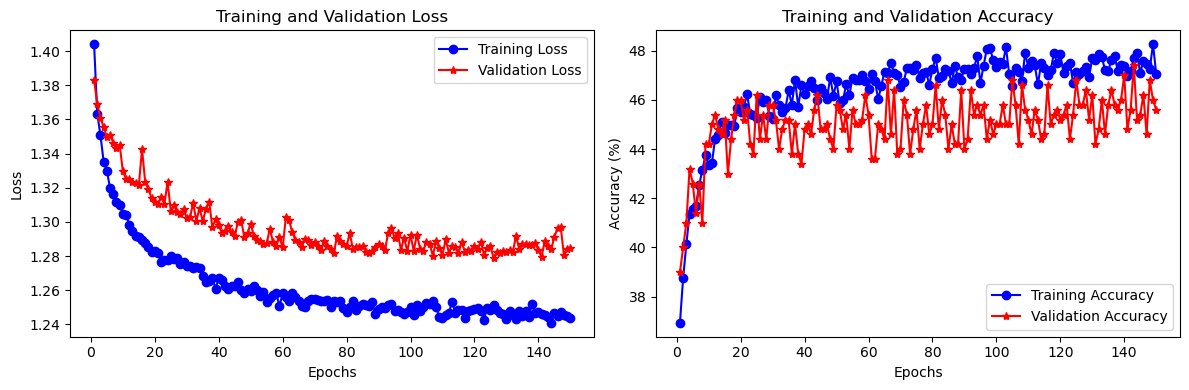

In [23]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 2
Hidden Layer Design: Simple linear layer\
Aggregation Method: Max pooling over the word vectors

### Intend to do: The max pooling method applied here is basically max-pooling over filters
e.g. \
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[1,2,3,4\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[2,0,4,8\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;\[9,0,2,1\]\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|&nbsp;&nbsp;|&nbsp;&nbsp;|&nbsp;&nbsp;|\
result: \[9,2,4,8\]
#### To introduce more randomness, we can choose to apply the max-pooling on a portion of randomly selected slots 

### The following implementation is simply doing 1D max pooling over a flattened sentence

In [45]:
# Define model 2 architecture
class QuestionClassifierModel2(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, sample_percent):
        super(QuestionClassifierModel2, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix,  padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
        
        self.sample_percent = sample_percent
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)
        
        # Aggregation Layer: Max pooling over the word vectors
        sentence_len = list(x.size())[1]
        x = torch.flatten(x, start_dim=1)
        max_pooling = nn.MaxPool1d(sentence_len, stride=sentence_len)
        x = max_pooling(x) # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim

        return x
    
#         The following implementation is the one that I described as intended in the heading
#         However, the performance is too bad that I commented it out first

#         original_tensor = x

#         # Determine the number of elements to extract based on the portion
#         num_elements = original_tensor.size(1)
#         num_elements_to_extract = int(num_elements * self.sample_percent)

#         # Generate random indices for sampling without replacement
#         random_indices = torch.randperm(num_elements)[:num_elements_to_extract]

#         # Use the random indices to extract the sampled data
#         sampled_data = original_tensor[:, random_indices, :]
#         pooled_data, _ = torch.max(sampled_data, dim=1)

#         x = self.output(pooled_data)  # Now, shape: batch_size x output_dim

In [50]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
MAX_POOLING_SAMPLE_PERCENT = 0.8

model = QuestionClassifierModel2(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, MAX_POOLING_SAMPLE_PERCENT)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

In [51]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer)

Epoch 1/100, Train Loss: 1.3832, Dev Loss: 1.3408, Train Accuracy: 38.73%, Dev Accuracy: 43.00%
Macro F1 Score: 0.23588477393791277
Micro F1 Score: 0.42999999999999994
Epoch 2/100, Train Loss: 1.2498, Dev Loss: 1.2288, Train Accuracy: 48.53%, Dev Accuracy: 52.00%
Macro F1 Score: 0.31675184909150567
Micro F1 Score: 0.47500000000000003
Epoch 3/100, Train Loss: 1.1678, Dev Loss: 1.1958, Train Accuracy: 54.75%, Dev Accuracy: 53.80%
Macro F1 Score: 0.3485213726782682
Micro F1 Score: 0.496
Epoch 4/100, Train Loss: 1.1222, Dev Loss: 1.1778, Train Accuracy: 56.60%, Dev Accuracy: 55.20%
Macro F1 Score: 0.36442561395335343
Micro F1 Score: 0.51
Epoch 5/100, Train Loss: 1.1000, Dev Loss: 1.1593, Train Accuracy: 57.51%, Dev Accuracy: 55.80%
Macro F1 Score: 0.37426202737711495
Micro F1 Score: 0.5196
Epoch 6/100, Train Loss: 1.0787, Dev Loss: 1.1424, Train Accuracy: 57.84%, Dev Accuracy: 54.60%
Macro F1 Score: 0.3825116169713905
Micro F1 Score: 0.524
Epoch 7/100, Train Loss: 1.0785, Dev Loss: 1.1460,

Macro F1 Score: 0.4406731053504763
Micro F1 Score: 0.578
Epoch 52/100, Train Loss: 1.0004, Dev Loss: 1.0668, Train Accuracy: 61.19%, Dev Accuracy: 59.40%
Macro F1 Score: 0.44085511627851837
Micro F1 Score: 0.5783076923076923
Epoch 53/100, Train Loss: 1.0034, Dev Loss: 1.0617, Train Accuracy: 61.01%, Dev Accuracy: 59.80%
Macro F1 Score: 0.4414245214583274
Micro F1 Score: 0.5786792452830188
Epoch 54/100, Train Loss: 0.9909, Dev Loss: 1.0592, Train Accuracy: 61.81%, Dev Accuracy: 59.00%
Macro F1 Score: 0.4416207970494764
Micro F1 Score: 0.5788888888888889
Epoch 55/100, Train Loss: 0.9933, Dev Loss: 1.0698, Train Accuracy: 61.65%, Dev Accuracy: 59.00%
Macro F1 Score: 0.44164578204342364
Micro F1 Score: 0.5790909090909091
Epoch 56/100, Train Loss: 0.9973, Dev Loss: 1.0708, Train Accuracy: 62.12%, Dev Accuracy: 59.80%
Macro F1 Score: 0.4417312862396301
Micro F1 Score: 0.5794285714285714
Epoch 57/100, Train Loss: 1.0001, Dev Loss: 1.0624, Train Accuracy: 61.43%, Dev Accuracy: 59.80%
Macro F1 

In [52]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.1333, Test Accuracy: 57.40%
Macro F1 Score on Test Set: 0.4270585058415305
Micro F1 Score on Test Set: 0.574


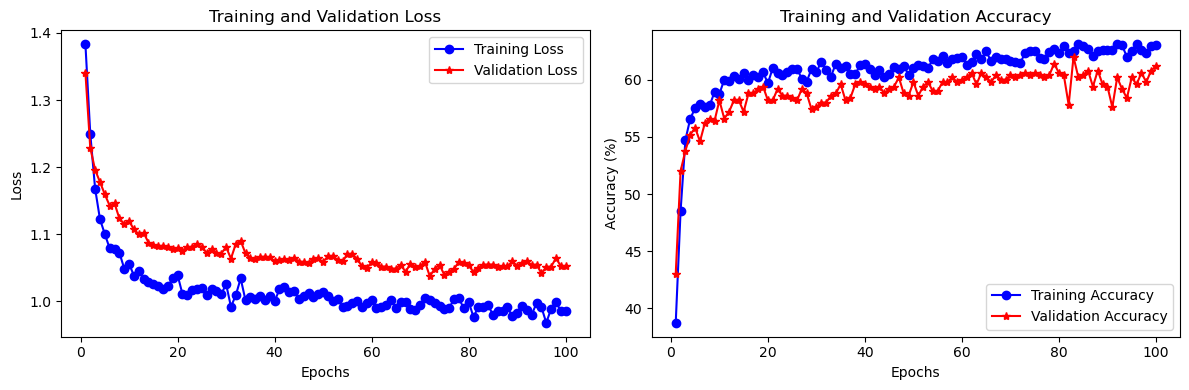

In [53]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 3
Hidden Layer Design: Recurrent neural network (RNN)\
Aggregation Method: Using the representation of the last word (RNN-based)

In [105]:
# Define model 3 architecture
class QuestionClassifierModel3(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel3, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.RNN(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the representation of the last word
        out, hidden = self.hidden(x)
        x = hidden[0] # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [106]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel3(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

In [107]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer)

Epoch 1/50, Train Loss: 1.4116, Dev Loss: 1.4077, Train Accuracy: 37.30%, Dev Accuracy: 38.60%
Macro F1 Score: 0.11882719900187147
Micro F1 Score: 0.386
Epoch 2/50, Train Loss: 1.3947, Dev Loss: 1.4301, Train Accuracy: 38.41%, Dev Accuracy: 38.80%
Macro F1 Score: 0.12411782879095194
Micro F1 Score: 0.387
Epoch 3/50, Train Loss: 1.3953, Dev Loss: 1.4279, Train Accuracy: 38.41%, Dev Accuracy: 38.40%
Macro F1 Score: 0.12115894733826053
Micro F1 Score: 0.386
Epoch 4/50, Train Loss: 1.3949, Dev Loss: 1.4125, Train Accuracy: 38.17%, Dev Accuracy: 38.60%
Macro F1 Score: 0.12060549891875191
Micro F1 Score: 0.386
Epoch 5/50, Train Loss: 1.3937, Dev Loss: 1.4091, Train Accuracy: 38.27%, Dev Accuracy: 38.80%
Macro F1 Score: 0.11965538273023842
Micro F1 Score: 0.3864
Epoch 6/50, Train Loss: 1.3946, Dev Loss: 1.4649, Train Accuracy: 38.37%, Dev Accuracy: 30.20%
Macro F1 Score: 0.13289343922162944
Micro F1 Score: 0.37233333333333335
Epoch 7/50, Train Loss: 1.4339, Dev Loss: 1.4195, Train Accuracy: 3

In [108]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 1.4923, Test Accuracy: 33.20%
Macro F1 Score on Test Set: 0.10945214619319446
Micro F1 Score on Test Set: 0.332


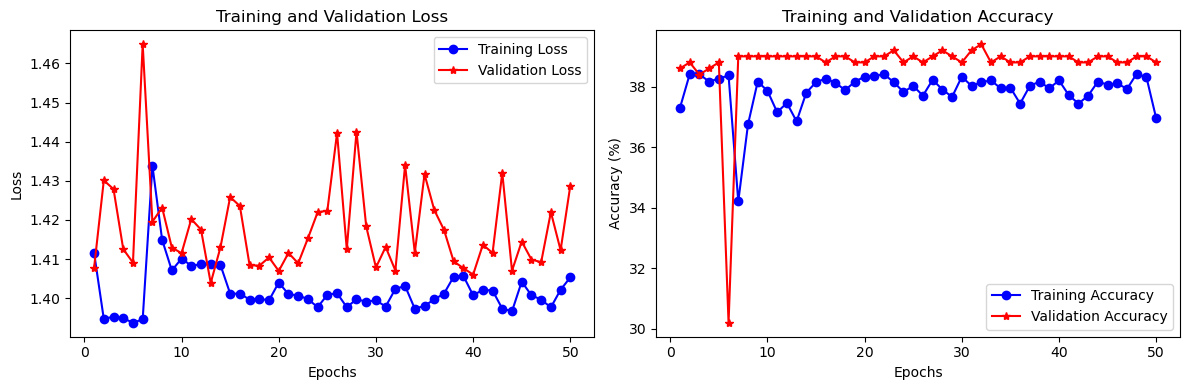

In [109]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

## Model 4
Hidden Layer Design: Hierarchical LSTM (LSTM at both word and sentence levels)\
Aggregation Method: Using the representation of the average of all the hidden layers

In [91]:
# Define model 4 architecture
class QuestionClassifierModel4(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers):
        super(QuestionClassifierModel4, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, padding_idx=word2idx['<PAD>'], freeze=True)
        
        # Hidden Layer
        self.hidden = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True)
        self.n_layers = n_layers
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # x shape: batch_size x seq_length
        x = self.embedding(x)    # Now, shape: batch_size x seq_length x embedding_dim
        
        # Aggregation Layer: Using the representation of the last word
        out, (hidden, cell) = self.hidden(x)
        x = torch.mean(hidden, dim=0) # Now, shape: batch_size x hidden_dim

        # Output Layer
        x = self.output(x)  # Now, shape: batch_size x output_dim
        
        return x

In [96]:
# Define hyperparameters
EMBEDDING_DIM = 300
HIDDEN_DIM = 150
# OUTPUT_DIM = len(label_list)  # Number of unique labels/labels
VOCAB_SIZE = len(word2idx)
LABELSET_SIZE = 5
HIDDEN_LAYERS = 1

model = QuestionClassifierModel3(EMBEDDING_DIM, HIDDEN_DIM, LABELSET_SIZE, HIDDEN_LAYERS)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50

In [97]:
# Train model
train_losses, dev_losses, train_accuracies, dev_accuracies = train_model(model, train_loader, dev_loader, num_epochs, loss_function, optimizer)

Epoch 1/50, Train Loss: 1.4137, Dev Loss: 1.4191, Train Accuracy: 37.50%, Dev Accuracy: 39.00%
Macro F1 Score: 0.12962184873949578
Micro F1 Score: 0.39
Epoch 2/50, Train Loss: 1.3927, Dev Loss: 1.4088, Train Accuracy: 38.11%, Dev Accuracy: 38.80%
Macro F1 Score: 0.12933038999264165
Micro F1 Score: 0.389
Epoch 3/50, Train Loss: 1.3849, Dev Loss: 1.4011, Train Accuracy: 38.47%, Dev Accuracy: 39.00%
Macro F1 Score: 0.12420424924552606
Micro F1 Score: 0.3893333333333333
Epoch 4/50, Train Loss: 1.3778, Dev Loss: 1.3959, Train Accuracy: 38.21%, Dev Accuracy: 39.00%
Macro F1 Score: 0.12144177401024978
Micro F1 Score: 0.3895
Epoch 5/50, Train Loss: 1.3747, Dev Loss: 1.3836, Train Accuracy: 37.98%, Dev Accuracy: 41.60%
Macro F1 Score: 0.14608231503048566
Micro F1 Score: 0.3948
Epoch 6/50, Train Loss: 1.3664, Dev Loss: 1.3731, Train Accuracy: 39.90%, Dev Accuracy: 40.80%
Macro F1 Score: 0.1607050771246951
Micro F1 Score: 0.3970000000000001
Epoch 7/50, Train Loss: 1.3616, Dev Loss: 1.3668, Train 

In [98]:
# Test model
test_loss, test_accuracy = evaluate_model(model, test_loader, loss_function)

Test Loss: 0.4321, Test Accuracy: 87.80%
Macro F1 Score on Test Set: 0.8739626582860467
Micro F1 Score on Test Set: 0.878


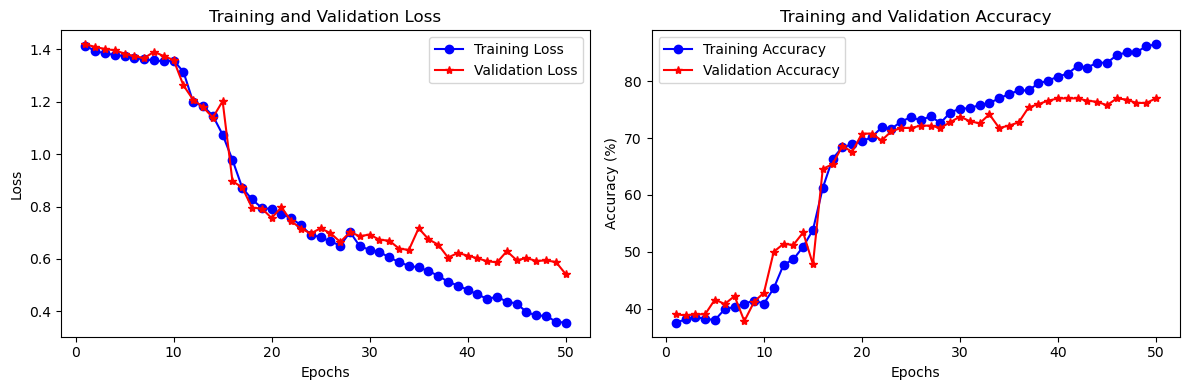

In [99]:
# Generate graphs to visualize the performance (epoch-accuracy)
visualize(train_losses, dev_losses, train_accuracies, dev_accuracies)

# **Below Code is still Bullshit       :-(**

In [18]:
def get_sentence_embeddings(sentence, model):
    embeddings = []
    for word in sentence.split():
        if word in model:
            embeddings.append(model[word])
        else:
            embeddings.append(np.zeros(300))
    return embeddings

# def embedding(df, model):
#     embeddings_list = []
#     new_labels_list = []
    
#     for index, row in df.iterrows():
#         sentence = row['text']
#         embeddings = get_sentence_embeddings(sentence, model)
        
#         # Appending the embeddings and the corresponding new_label to the lists
#         embeddings_list.append(embeddings)
#         new_labels_list.append(row['new_label'])
    
#     # Creating the new dataframes
#     X_train = pd.DataFrame({'embeddings': embeddings_list})
#     Y_train = pd.DataFrame({'new_label': new_labels_list})
    
#     return X_train, Y_train

def embedding(df, model):
    embeddings_list = []
    new_labels_list = []
    
    for index, row in df.iterrows():
        sentence = row['text']
        embeddings = get_sentence_embeddings(sentence, model)
        
        # Appending the embeddings and the corresponding new_label to the lists
        embeddings_list.append(embeddings)
        new_labels_list.append(row['new_label'])
    
    return embeddings_list, new_labels_list

In [19]:
X_train, Y_train = embedding(train_data, word2idx)
X_dev, Y_dev = embedding(dev_data, word2idx)


## Use a simple linear layer + Averaging all word vectors


In [20]:
import numpy as np

# # Convert object-type DataFrame to list of arrays
# X_train_arrays = list(X_train.apply(lambda x: np.array(x)))

# Stack arrays
X_train_stacked = np.vstack(X_train)

# Convert to PyTorch tensor
X_train_tensor = torch.tensor(X_train_stacked, dtype=torch.float32)


# # Convert object-type DataFrame to list of arrays
# X_test_arrays = list(X_test.apply(lambda x: np.array(x)))

# Stack arrays
X_dev_stacked = np.vstack(X_dev)

# Convert to PyTorch tensor
X_dev_tensor = torch.tensor(X_dev_stacked, dtype=torch.float32)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (8,) + inhomogeneous part.

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['new_label'])
y_dev = label_encoder.transform(dev_data['new_label'])

y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_dev_tensor = torch.tensor(y_dev, dtype=torch.int64)

In [ ]:
X_train_tensor.shape

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the model architecture
class QuestionClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(QuestionClassifier, self).__init__()
        
        # Hidden Layer
        self.hidden = nn.Linear(embedding_dim, hidden_dim)
        
        # Output Layer
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # x shape: batch_size x seq_length x embedding_dim
        x = self.hidden(x)
        x = torch.relu(x)
        
        # Aggregation Layer: Averaging word vectors across sequence length
        x = torch.mean(x, dim=1)
        
        # Output Layer
        x = self.output(x)
        return x

# Define Hyperparameters
EMBEDDING_DIM = 300  # As each word vector is of shape (300,)
HIDDEN_DIM = 128
OUTPUT_DIM = 5  # 4 integer classes + 1 "OTHERS"
EPOCHS = 100
LR = 0.001

# # Convert dataframes to tensors
# X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
# Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
# Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.long)

# Instantiate the model
model = QuestionClassifier(EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

# Training loop
for epoch in range(EPOCHS):
    model.train()
    
    optimizer.zero_grad()
    
    predictions = model(X_train_tensor)
    loss = criterion(predictions, Y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch: {epoch}/{EPOCHS}, Loss: {loss.item()}")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    _, predicted = test_predictions.max(1)
    accuracy = (predicted == Y_test_tensor).float().mean()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


In [ ]:
class QuestionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(QuestionClassifier, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.hidden(x)
        x = torch.mean(x, dim=1)  # Aggregation Layer
        x = self.output(x)
        return nn.functional.softmax(x, dim=1)

In [ ]:
# Hyperparameters
input_dim = 300  # word2vec dimensions
hidden_dim = 128
output_dim = 5  # 5 classes
lr = 0.01

# Model, Loss, Optimizer
model = QuestionClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training
epochs = 1000

train_data = pd.DataFrame()  # Assuming train_data is already loaded as mentioned
dev_data = pd.DataFrame()    # Assuming dev_data is also loaded



In [ ]:
for epoch in range(epochs):
    model.train()
    train_losses = []
    for index, row in train_data.iterrows():
        optimizer.zero_grad()
        sentence = row['text']
        label = row['new_label']

        sentence_embeddings = torch.tensor(get_sentence_embeddings(sentence, glove_vectors)).float().unsqueeze(0)
        
        outputs = model(sentence_embeddings)
        loss = criterion(outputs, torch.tensor([label]).long())
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
    model.eval()
    predictions = []
    true_labels = []
    for index, row in dev_data.iterrows():
        sentence = row['text']
        label = row['new_label']
        true_labels.append(label)
        
        with torch.no_grad():
            sentence_embedding = torch.tensor(get_sentence_embedding(sentence, glove_vectors)).float().unsqueeze(0)
            outputs = model(sentence_embedding)
            predicted_class = torch.argmax(outputs).item()
            predictions.append(predicted_class)
            
    dev_accuracy = accuracy_score(true_labels, predictions)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {np.mean(train_losses)}, Dev Accuracy: {dev_accuracy:.2f}")

print("Training complete.")

In [ ]:
# Function to get the average word vector for a sentence
def sentence_vector(sentence):
    words = sentence.split()
    # Split the sentence into words.

    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    # Get the word vector for each word in the sentence if it exists in glove_vectors.


    if len(vectors) == 0: # to avoid empty lists
        return np.zeros(300)
    # If no words from the sentence are in the word vectors, return a vector of zeros.

    return np.mean(vectors, axis=0)
# Return the average word vector for the sentence.

train_data['avg_vector'] = train_data['text'].apply(sentence_vector)
# Compute the average word vector for each sentence in the training data.

X_train = np.vstack(train_data['avg_vector'].values)
# Stack the average vectors to form the training data.

y_train = pd.get_dummies(train_data['new_label']).values
# Convert the new labels to one-hot encoded vectors.

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# Convert the training data to a PyTorch tensor.

y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)
# Convert the one-hot encoded labels to their corresponding class indices.


In [ ]:
# Neural Network Model with a simple linear layer
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleClassifier, self).__init__()
        # Initialize the parent class.
        
        self.fc = nn.Linear(input_dim, output_dim)
        # Define a fully connected layer.

    def forward(self, x):
        return self.fc(x)
    # Define the forward pass to return the output of the linear layer.

input_dim = 300  # as we're using word2vec-google-news-300
# Define the input dimension based on the word vector size.

output_dim = 5  # for our 5 new classes
# Define the output dimension based on the number of new classes.

model = SimpleClassifier(input_dim, output_dim)
# Initialize the model.

criterion = nn.CrossEntropyLoss()
# Define the loss function (cross entropy).

optimizer = optim.Adam(model.parameters(), lr=0.001)
# Define the optimizer (Adam) with a learning rate.

# Training
epochs = 5000
# Set the number of epochs.

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()
  


    # Store metrics for visualization
    all_metrics['A']['epochs'].append(epoch)
    all_metrics['A']['accuracy'].append(accuracy)
    all_metrics['A']['loss'].append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")
    # Print the loss and accuracy for each epoch.


In [ ]:
visualize_metrics(all_metrics['A'])

## Use a feedforward network which is a combination of a linear transformation and a nonlinear activation function

## Max pooling over the word vectors

In [ ]:
def sentence_vector(sentence):
    words = sentence.split()
    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    if len(vectors) == 0: # if no words in the sentence have embeddings
        return np.zeros(300)
    return np.max(vectors, axis=0) # max pooling across the words

train_data['maxpooled_vector'] = train_data['text'].apply(sentence_vector)

X_train = np.vstack(train_data['maxpooled_vector'].values)
y_train = pd.get_dummies(train_data['new_label']).values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)

In [ ]:
train_data.head()

In [ ]:
# Define the neural network model with feedforward layers
class FeedForwardClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardClassifier, self).__init__()
        
        # First linear layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        
        # Second linear layer that outputs class probabilities
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Apply first linear transformation
        x = self.fc1(x)
        
        # Apply ReLU activation function
        x = nn.ReLU()(x)
        
        # Apply second linear transformation
        return self.fc2(x)

input_dim = 300  # as we're using word2vec-google-news-300
hidden_dim = 1000  # can be adjusted based on performance
output_dim = 5   # for our 5 new classes

model = FeedForwardClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()

    # Store metrics for visualization
    all_metrics['B']['epochs'].append(epoch)
    all_metrics['B']['accuracy'].append(accuracy)
    all_metrics['B']['loss'].append(loss.item())
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")


In [ ]:
visualize_metrics(all_metrics['B'])

##  Recurrent neural network
##  Aggregation Layer: Taking the representation of the last word (useful if using RNNs)

In [ ]:
def sentence_matrix(sentence, max_len=30):
    words = sentence.split()[:max_len]  # truncate if necessary
    vectors = [glove_vectors[word] for word in words if word in glove_vectors]
    while len(vectors) < max_len:  # pad if necessary
        vectors.append(np.zeros(300))
    return np.array(vectors)

train_data['vector_matrix'] = train_data['text'].apply(sentence_matrix)

X_train = np.stack(train_data['vector_matrix'].values)
y_train = pd.get_dummies(train_data['new_label']).values

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.int64)

In [ ]:
train_data.head()

In [ ]:
# Define the neural network model with an RNN layer
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        
        # RNN layer
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        
        # Linear layer that outputs class probabilities
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Pass the input through the RNN layer
        out, _ = self.rnn(x)
        
        # Only take the output from the final timestep
        out = out[:, -1, :]
        
        # Pass the final output through the linear layer
        return self.fc(out)

input_dim = 300  # as we're using word2vec-google-news-300
hidden_dim = 100  # can be adjusted based on performance
output_dim = 5   # for our 5 new classes

model = RNNClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs, 1)
    accuracy = (predicted == y_train_tensor).float().mean().item()

    # Store metrics for visualization
    all_metrics['C']['epochs'].append(epoch)
    all_metrics['C']['accuracy'].append(accuracy)
    all_metrics['C']['loss'].append(loss.item())
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {accuracy}")


In [ ]:
visualize_metrics(all_metrics['C'])